# Inaugural Project

Imports and set magics:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # baseline module

# Predefine options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 14})

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
from ConsumerProblem import HouseholdSpecializationModelClass


# Question 1

1. Improve explanation of code

We first update the HouseholdSpecializationModelClass such that the consumption of home production supports $\sigma\ne1$.
We then show how $\frac{H_F}{H_M}$ changes for each combination of $\alpha\in\{0.25,0.50,0.75\}$ and $\sigma\in\{0.5,1.0,1.5\}$.

1. When $\alpha$ increases the productivity of females relative to males increases. Relatively more productive females increases the optimal quantity of female relative to male household work.
2. As $\sigma$ increases the substitutability between male and female household work increases. Higher substitutability cp. magnifies a given difference in household work between males and females.

The differences in home productivity give rise to differences in relative home production as households make a larger division of labor between work in the household and in the market. The potential for division of labor increases as substitutability increases. 

In [2]:
#a. Setting parameters and generating empty lists
alpha_list = [0.25, 0.50, 0.75]
sigma_list = [0.5, 1.0, 1.5]
alpha_list2 = []
sigma_list2 = []
HF_list = []
HM_list = []
HF_HM_list = []

#b. Generating Household as class
Household = HouseholdSpecializationModelClass()

#c. Loops through each combination of alpha and sigma in list. Solves the model for each combination and appends result to empty lists
for i_alpha,alpha in enumerate(alpha_list):
    for i_sigma,sigma in enumerate(sigma_list):
            #c.1 Sets parameters in class equal to parameter in list
            Household.par.alpha = alpha
            Household.par.sigma = sigma

            #c.2 Solves model
            result = Household.solve_discrete()

            #c.3 Appends results
            alpha_list2.append(alpha)
            sigma_list2.append(sigma)
            HF_list.append(result.HF)
            HM_list.append(result.HM)
            HF_HM_list.append(result.HF/result.HM)

#d. Generating DataFrame df to show results
df= pd.DataFrame().from_dict({'alpha':alpha_list2,'sigma':sigma_list2,'HF':HF_list,'HM':HM_list,'HF/HM':HF_HM_list})
df['HF/HM'] = df['HF/HM'].apply(lambda x: f'{x:2.2f}') 
df

c:\Users\MUHH\Documents\UNIVERSITETET\Introductio to numerical programming and analysis\INTRO TO PROGRAMMING\projects-2023-magnus-kristian\inauguralproject\ConsumerProblem.py:62: RuntimeWarning: divide by zero encountered in reciprocal
  H=((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))


,alpha,sigma,HF,HM,HF/HM
0,0.25,0.5,3.0,5.5,0.55
1,0.25,1.0,2.0,6.5,0.31
2,0.25,1.5,1.5,7.0,0.21
3,0.50,0.5,4.5,4.5,1.00
4,0.50,1.0,4.5,4.5,1.00
5,0.50,1.5,4.5,4.5,1.00
6,0.75,0.5,5.5,3.0,1.83
7,0.75,1.0,6.5,2.0,3.25
8,0.75,1.5,7.0,1.5,4.67


# Question 2

To test how changes in the relative wages affect the ratio of hours worked in the household (in the baseline model case with equal productivity), we fix the male wage at 1 and loop through 5 values of female wages. In each case we solve the model and store the log of relative hours worked and the log of relative wages. We plot the results in a graph.

<b>Results</b>

1. In the case of wage parity both members will work the same number of hours in the household. 

2. Typically, when the female hourly wage is lower (higher) than the male hourly wage the female will work more (fewer) hours in the household than the male. For instance, when the female relative wage is 20 percent lower (higher) the female will work about 20 percent more (fewer) hours in the household than the male. 

However, from the graph we see that there is an interval of relative wages around 1 where both members will work the same number of hours in the household despite the relative wage difference. This is a consequence of the discrete choice set of hours worked meaning that there are threshold values of relative wages where the optimal choice of hours worked in the household changes discretely.

<b>Reflections</b>
1. The asymmetry in the graph is an artifact of the discrete nature of the problem.

2. Suppose we increased the choice set of hours worked then graph would approach a continuous line (as seen in question 3).

3. Also given choice set of possible hours worked, if we solved the model for a finer grid of relative wages then the graph would reveal that there are actually more hidden kinks in the utility optimizing ratio of hours worked in the household in the interval of a +/- 20 percent relative wage difference (not shown in this Jypiter notebook).



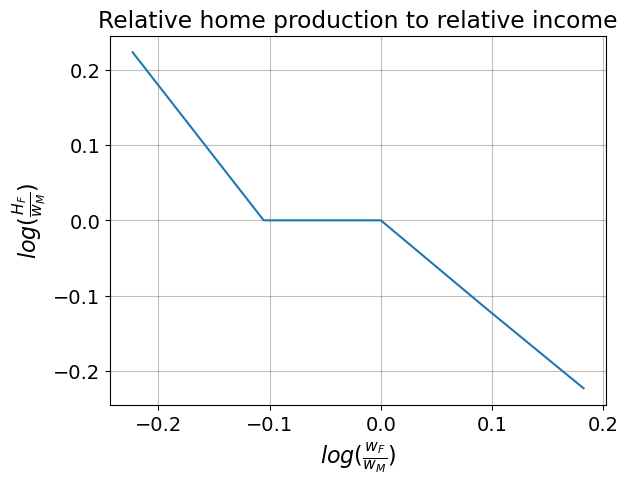

In [3]:
#a. Setting parameters
log_HF_HM_list = []
log_wF_wM_list = []

#b. Generating Household
Household = HouseholdSpecializationModelClass()

#c. Loops through values of wF_vec, returns (x,y)-variables
for wF in Household.par.wF_vec:
            Household.par.wF = wF
            result = Household.solve_discrete()
            log_HF_HM_list.append(np.log(result.HF/result.HM))
            log_wF_wM_list.append(np.log(Household.par.wF/Household.par.wM))

# d. create the figure
fig = plt.figure()

# e. plot
ax = fig.add_subplot(1,1,1)

ax.plot(log_wF_wM_list,log_HF_HM_list)

ax.set_title('Relative home production to relative income')
ax.set_xlabel(r'$log(\frac{w_F}{w_M})$', fontsize=16)
ax.set_ylabel(r'$log(\frac{H_F}{w_M})$', fontsize=16);

# Question 3

We modify the code in the HouseholdSpecializationModelClass adding a new function called "solve" that solves the model for a continuous choice set.

To solve the model, we use the Nelder-Mead optimization method to find the optimal choice of LM, HM, LF, HF. For each variable we set bounds that hours worked must be in the interval (0,24). In practice, we only allow hours worked greater than a small positive number (10 ** - 8) and require hours worked at most slightly less than 24 (24 - 10 ^^ - 8). In principle, the solution could allow the sum of hours worked in both the labor market and the household to exceed 24 however that is not the case in practice.

To start the optimization procedure, we guess at an initial symmetric solution of 5 hours worked in both the labor market and the household for both the male and female member. The guess is set close to the optimal choice in the baseline model in the case of wage parity (see question 1).

<b>Results</b>

We plot the results and find a linear relationship (with a slope of -1) between log of relative hours worked in the household and log of relative wages.

I.e. the model implies that the elasticity between the optimal choice of relative hours worked and the relative wage is such that when the relative wage of females increases by 1 percent then the female will work 1 percent fewer hours in the household than the male.

<b>Thoughts for futher revisions</b>

In the future we could consider modifying the optimization method to guarantee that total hours worked do not exceed 24. We could also discuss the best choice of optimization method.



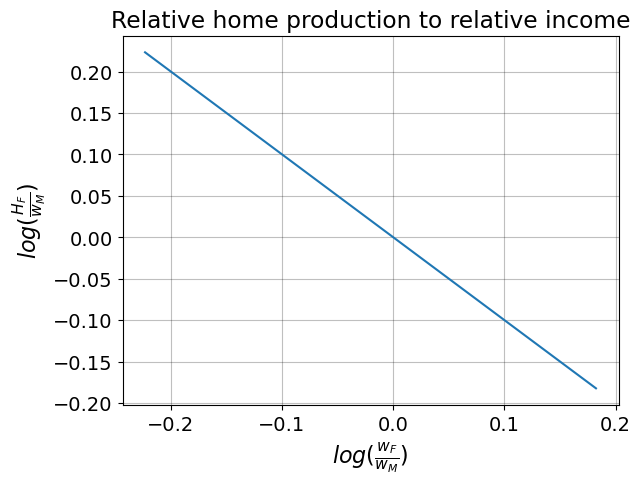

In [4]:
#a. Setting parameters
log_HF_HM_list = []
log_wF_wM_list = []

#b. Generating Household
Household = HouseholdSpecializationModelClass()

#c. Loops through values of wF_vec, returns (x,y)-variables
for wF in Household.par.wF_vec:
            Household.par.wF = wF
            result = Household.solve()
            log_HF_HM_list.append(np.log(result.HF/result.HM))
            log_wF_wM_list.append(np.log(Household.par.wF/Household.par.wM))

# d. create the figure
fig = plt.figure()

# e. plot
ax = fig.add_subplot(1,1,1)

ax.plot(log_wF_wM_list,log_HF_HM_list)

ax.set_title('Relative home production to relative income')
ax.set_xlabel(r'$log(\frac{w_F}{w_M})$', fontsize=16)
ax.set_ylabel(r'$log(\frac{H_F}{w_M})$', fontsize=16);

# Question 4

In section 1, we have outlined our methodological approach to choosing values of $\alpha$ and $\beta$ such that $(\beta_0 - \hat{\beta_0})^2 + (\beta_1 - \hat{\beta_1})^2$ is minimized. In section 2, we have illustrated in a table the degree to which the model fits the data and interpreted our results.

1. $\bold{Method}$

The methodological approach has been to make initial guesses of the values of alpha and beta that minimize the squared deviation of the beta parameters by changing alpha and sigma. 

The way in which this has been done is by creating an objective function that for given alphas and sigmas returns the squared deviation of the betas from realistic parameter values. This methods cosnsits of a range of steps: 

- Firstly, we simulate optimal household behavior for given values of alpha and sigma. This is done by looping through the range of values $w_F$ can take i.e., $w_F \in [0.8, 0.9, 1.0, 1.1, 1.2]$ and subsequently estimating the optimal values of $L_M, L_F, H_M, H_F$ and the associated utility level. 

- Secondly, for a given household behavior we run the regression to estimate the beta values. 

- Thirdly, for the beta values i.e., $\beta_0$ and $\beta_1$ we calculate the squared deviation from the target beta parameters. 

- Lastly, this process is repeated until the squared deviation between the betas is minimized by changing alpha and sigma. 

2. $\bold{Interpretation \space of \space results}$

The values of alpha and beta that minimize the squared deviation between the betas are: $\alpha = 0.982$ and $\sigma = 0.1$. 

Alpha denotes the productivity in home production for females relative to males i.e., $\frac{\alpha}{1-\alpha}$. The value of alpha is rather high in this model indicating that females are substantially more productive in home production in comparison to men. 

sigma, on the other hand, is the elasticity of substitution and hence a measure of the input substitution between female and male labor keeping output unchanged. The elasticity of substitution is rather low indicating that the substitutability between female and male labor in home production is rather low. This is evident as, a 0.1% decrease in female labor can be substituted with 1.0% percent male labor keeping output unchaged. 

In comparison to this, the table below illustrates the respective shares of $L_M, H_M, L_F$ and $H_F$ when $W_F$ increases with 0.1 unit in the range from 0.8 to 1.2. The interpreted results are:

- When $W_F$ increases with 0.1 unit $L_M$ decreases in the range 6-9% 

- When $W_F$ increases with 0.1 unit $H_M$ decreases in the range 0.5-1.5%

- When $W_F$ increases with 0.1 unit $L_F$ increases in the range 9-28%

- When $W_F$ increases with 0.1 unit $H_F$ decreases in the range 2-2.5% 

These reults seem to provide some evident to support the estimated values of alpha and sigma. Increases in female labor substantially increased female labor market participation but only marginally decreases female home production participation. Furthermore, increases in female labor market wages only decreases the males participation in home production with 0-5-1.5%. This substantiates the fact that females are more produtive in home production and that the elasticity of substitution between famale and male labor is rather low. Notably, increases in female labor market wages decreases male labor market participation with about 6-9%. Hence, there appears to be a greater degree of subtitution between female and male labor market participation but a low degree in home production. 

In [5]:
#a. Generate Household
Household=HouseholdSpecializationModelClass()

#b. Based on initial guesses of alpha and beta, minimize the sq. dev. from beta0 and beta1, by changina alpha and sigma.
Household.estimate()

#c. Print resuls
df2= pd.DataFrame().from_dict({'wF':Household.par.wF_vec,'LM':Household.sol.LM_vec,'HM':Household.sol.HM_vec,'LF':Household.sol.LF_vec,'HF':Household.sol.HF_vec})
print(df2)
print(f'\n alpha = {Household.sol.alpha:.3f}, sigma = {Household.sol.sigma:.3f} -> beta0 = {Household.sol.beta0:.3f}, beta1 = {Household.sol.beta1:.3f}')

c:\Users\MUHH\Documents\UNIVERSITETET\Introductio to numerical programming and analysis\INTRO TO PROGRAMMING\projects-2023-magnus-kristian\inauguralproject\ConsumerProblem.py:62: RuntimeWarning: divide by zero encountered in double_scalars
  H=((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
c:\Users\MUHH\Documents\UNIVERSITETET\Introductio to numerical programming and analysis\INTRO TO PROGRAMMING\projects-2023-magnus-kristian\inauguralproject\ConsumerProblem.py:62: RuntimeWarning: overflow encountered in double_scalars
  H=((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))


    wF        LM        HM        LF        HF
0  0.8  6.148468  3.600292  2.306947  5.492117
1  0.9  5.685677  3.544115  2.963634  5.343124
2  1.0  5.223590  3.501477  3.501491  5.223559
3  1.1  4.773427  3.469161  3.940532  5.126260
4  1.2  4.342068  3.444625  4.298108  5.045946

 alpha = 0.982, sigma = 0.100 -> beta0 = 0.400, beta1 = -0.100


## Question 5

The parameter $\alpha=$ is set equal to 0.5, which is equivalent to assuming that the male and female member of the household is equally productive working at home. To be able to match the data we incorporate a disutillity parameter $\mu$ in the model. The new utility function for the household thus becomes:

$\frac{Q^{1-p}}{1-p}-\nu(\frac{T_M^{1+\frac{1}{\epsilon}}}{1+\frac{1}{\epsilon}}+\frac{T_F^{1+\frac{1}{\epsilon}}}{1+\frac{1}{\epsilon}})-\mu\max(\frac{w_M}{w_F},1)H_M$

The new disutility of the household increasing in the number of hours the male member of the household works at home. The disutility increases in the relative wage for men $\frac{w_M}{w_F}$ for $w_M>w_F$, and is constant for $w_M \le w_F$. The disutility is scaled with the parameter $\mu$.

The interpretation of the extension is that traditional cultural gender norms could lead men to have a higher disutility of doing work at home. 

We extend the code that is used in Question 4 

In [ ]:
#a. Generate Household
Household=HouseholdSpecializationModelClass()

#b. Based on initial guesses of alpha and beta, minimize the sq. dev. from beta0 and beta1, by changina alpha and sigma.
#The method has to be augmented, such that only one parameter can be chosen for minimization.
Household.estimate_5()

#c. Print resuls
df2= pd.DataFrame().from_dict({'wF':Household.par.wF_vec,'LM':Household.sol.LM_vec,'HM':Household.sol.HM_vec,'LF':Household.sol.LF_vec,'HF':Household.sol.HF_vec})
print(df2)
print(f'\n mu = {Household.par.mu:.3f}, sigma = {Household.sol.sigma:.3f}, alpha = {Household.par.alpha:.3f} -> beta0 = {Household.sol.beta0:.3f}, beta1 = {Household.sol.beta1:.3f}')